In [37]:
import pandas as pd
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/nic-
[nltk_data]     macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/nic-
[nltk_data]     macbook/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nic-
[nltk_data]     macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing and generating Word2Vec

In [11]:
df = pd.read_csv("reviews.csv")

In [12]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [13]:
def clean_text(text):
    tokens = word_tokenize(text)
    lower = [token.lower() for token in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lower]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    non_stop_words = [w for w in words if not w in stop_words]
    return " ".join(non_stop_words)

In [14]:
df["Review_cleaned"] = df["Review"].apply(clean_text)

In [15]:
def categorize_rating(rating):
    if rating < 3:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

In [16]:
df["Rating_category"] = df["Rating"].apply(categorize_rating)

In [17]:
tokenized_reviews = [review.split() for review in df["Review_cleaned"]]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

In [18]:
def get_average_word2vec(review, model):
    words = review.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['vector'] = df['Review_cleaned'].apply(lambda x: get_average_word2vec(x, word2vec_model))

## Fitting and Evaluating Model

In [19]:
X = np.vstack(df['vector'].values)
y = df['Rating_category'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.72      0.87      0.79      4961
     neutral       0.30      0.01      0.03      1380
    positive       0.82      0.86      0.84      5978

    accuracy                           0.77     12319
   macro avg       0.61      0.58      0.55     12319
weighted avg       0.72      0.77      0.73     12319



In [34]:
df['Predicted_sentiment'] = clf.predict(np.vstack(df['vector'].values))

In [35]:
np.mean(df["Review_sentiment"] == df['Predicted_sentiment'])

0.9910867941682632

In [36]:
df.to_csv("reviews_classified.csv")

## Plotting Learning Curve

In [38]:
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, scoring='accuracy')
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)

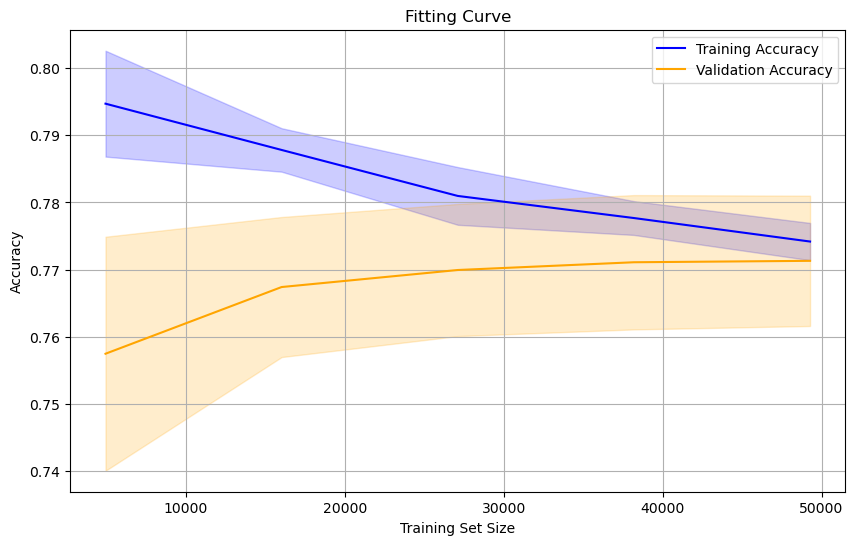

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, valid_mean, label="Validation Accuracy", color="orange")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color="orange")

plt.title("Fitting Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()